# Time-domain examples: step and impulse responses

These examples compare the analytical solution with `empymod` for time-domain step and impulse responses for inline, x-directed source and receivers, for the three different frequency-to-time methods **QWE**, **FHT**, and **FFTLog**. Which method is faster and which is more precise depends on the model (land or marine, source/receiver at air-interface or not) and the response (step or impulse).

Note: You must install FFTLog to run these examples, see <https://github.com/prisae/fftlog>.

In [1]:
import numpy as np
from scipy.special import erf
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.constants import mu_0       # Permeability of free space  [H/m]

import fftlog
from empymod import time

# Style adjustments
%matplotlib inline
plt.style.use('ggplot')
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['text.usetex'] = True
rcParams['font.serif'] = 'Computer Modern Roman'
rcParams['font.family'] = 'serif'
rcParams['font.style'] = 'normal'
colors = [color['color'] for color in list(rcParams['axes.prop_cycle'])]

## Analytical solutions for source and receiver at the interface between two half-spaces

The time-domain step and impulse responses for a source at the origin ($x_s = y_s = z_s = 0\,$m) and an in-line receiver at the surface ($y_r = z_r = 0\,$m), is given by the following equations, where $\rho_h$ is horizontal resistivity ($\Omega\,$m), $\lambda$ is anisotropy (-), with $\lambda = \sqrt{\rho_v/\rho_h}$, $r$ is offset (m), $t$ is time (s), and
$\tau_h = \sqrt{\mu_0 r^2/(\rho_h t)}$; $\mu_0$ is the magnetic permeability of free space (H/m).


### Time Domain: Step Response $\mathbf{\mathcal{H}(t)}$

$$
    E_x(\rho_h,\lambda,r,t) = \frac{\rho_h}{2 \pi r^3} \left[ 2\lambda +
    \rm{erf}\left(\frac{\tau_h}{2}\right) - 2\lambda
    \rm{erf}\left(\frac{\tau_h}{2\lambda}\right) + \frac{\tau_h}{\sqrt{\pi}}
    \exp\left(- \frac{\tau_h^2}{4\lambda^2}\right)   \right]
$$

### Time Domain: Impulse Response $\mathbf{\delta(t)}$

$$
    \dot{E}_x(\rho_h,\lambda,r,t) = \frac{\rho_h}{2 \pi r^3} \left[ \delta(t) +
    \frac{\tau_h}{2t\sqrt{\pi}} \left\{ - \exp\left(-\frac{\tau_h^2}{4}\right) +
    \left( \frac{\tau_h^2}{2 \lambda^2} + 1 \right) \exp\left(-
    \frac{\tau_h^2}{4 \lambda^2}\right) \right\} \right]
$$



### Reference
Equations 3.2 and 3.3 in Werthmüller, D., 2009, Inversion of multi-transient EM data from anisotropic media: M.S. thesis, TU Delft, ETH Zürich, RWTH Aachen; http://repository.tudelft.nl/islandora/object/uuid:f4b071c1-8e55-4ec5-86c6-a2d54c3eda5a.

### Analytical functions

In [2]:
def ee_xx_impulse(res, aniso, off, time):
    """VTI-Halfspace impulse response, xx, inline.

    res   : horizontal resistivity [Ohm.m]
    aniso : anisotropy [-]
    off   : offset [m]
    time  : time(s) [s]
    """
    tau_h = np.sqrt(mu_0*off**2/(res*time))
    t0 = tau_h/(2*time*np.sqrt(np.pi))
    t1 = np.exp(-tau_h**2/4)
    t2 = tau_h**2/(2*aniso**2) + 1
    t3 = np.exp(-tau_h**2/(4*aniso**2))
    Exx = res/(2*np.pi*off**3)*t0*(-t1 + t2*t3)
    Exx[time == 0] = res/(2*np.pi*off**3)  # Delta dirac part
    return Exx

def ee_xx_step(res, aniso, off, time):
    """VTI-Halfspace step response, xx, inline.

    res   : horizontal resistivity [Ohm.m]
    aniso : anisotropy [-]
    off   : offset [m]
    time  : time(s) [s]
    """
    tau_h = np.sqrt(mu_0*off**2/(res*time))
    t0 = erf(tau_h/2)
    t1 = 2*aniso*erf(tau_h/(2*aniso))
    t2 = tau_h/np.sqrt(np.pi)*np.exp(-tau_h**2/(4*aniso**2))
    Exx = res/(2*np.pi*off**3)*(2*aniso + t0 - t1 + t2)
    return Exx

## Example 1: Source and receiver at z=0m

Comparison with analytical solution; put 1 mm below the interface, as they would be regarded as in the air by `emmod` otherwise.

In [3]:
src = [0, 0, 0.001]          # Source at origin, slightly below interface
rec = [6000, 0, 0.001]       # Receivers in-line, 0.5m below interface
res = [1e23, 10]             # Resistivity: [air, half-space]
aniso = [1, 2]               # Anisotropy: [air, half-space]
t = np.logspace(-2, 1, 301)  # Desired times (s)

# Collect parameters
inparg = {'src': src, 'rec': rec, 'depth': 0, 'time': t, 'res': res, 'aniso': aniso, 'verb': 1,
          'ht': 'qwe', 'htarg': [1e-8, 1e-20, 31, 100]}  # Use QWE for Hankel transform

### Impulse response

In [4]:
ex = ee_xx_impulse(res[1], aniso[1], rec[0], t)

inparg['signal'] = 0 # signal 0 = impulse
print('QWE')
qwe = time(**inparg, ft='qwe')
print('FHT (Sine)')
sin = time(**inparg, ft='sin')
print('FFTLog')
ftl = time(**inparg, ft='fftlog')

QWE
* WARNING :: Fourier-QWE used all 200 intervals; set `maxint` higher.

:: empymod END; runtime = 0:00:02.006204 ::

FHT (Sine)

:: empymod END; runtime = 0:00:02.486983 ::

FFTLog

:: empymod END; runtime = 0:00:00.686480 ::



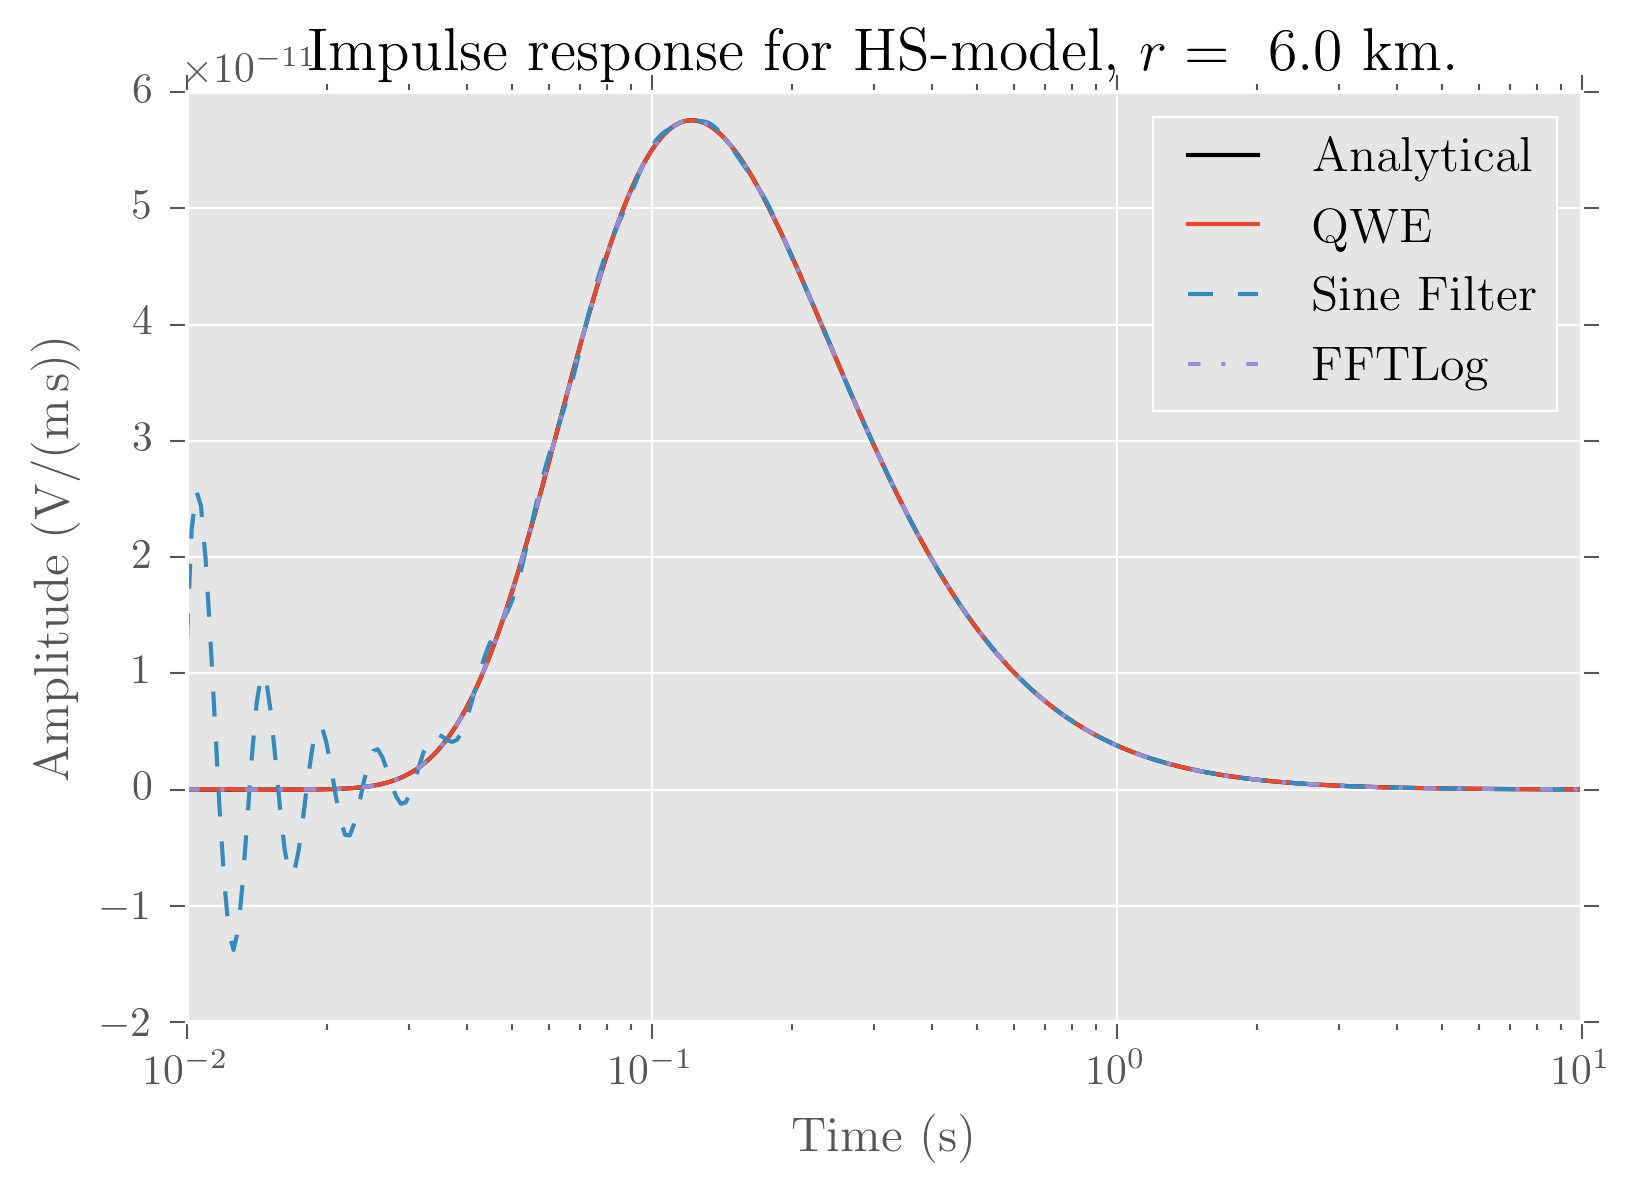

In [5]:
plt.figure()
plt.title(r'Impulse response for HS-model, $r =\ $ ' + str(rec[0]/1000) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel(r'Amplitude (V/(m\,s))')
plt.semilogx(t, ex, 'k-', label='Analytical')
plt.semilogx(t, qwe, '-', label='QWE')
plt.semilogx(t, sin, '--', label='Sine Filter')
plt.semilogx(t, ftl, '-.', label='FFTLog')
plt.legend(loc='best')
plt.show()

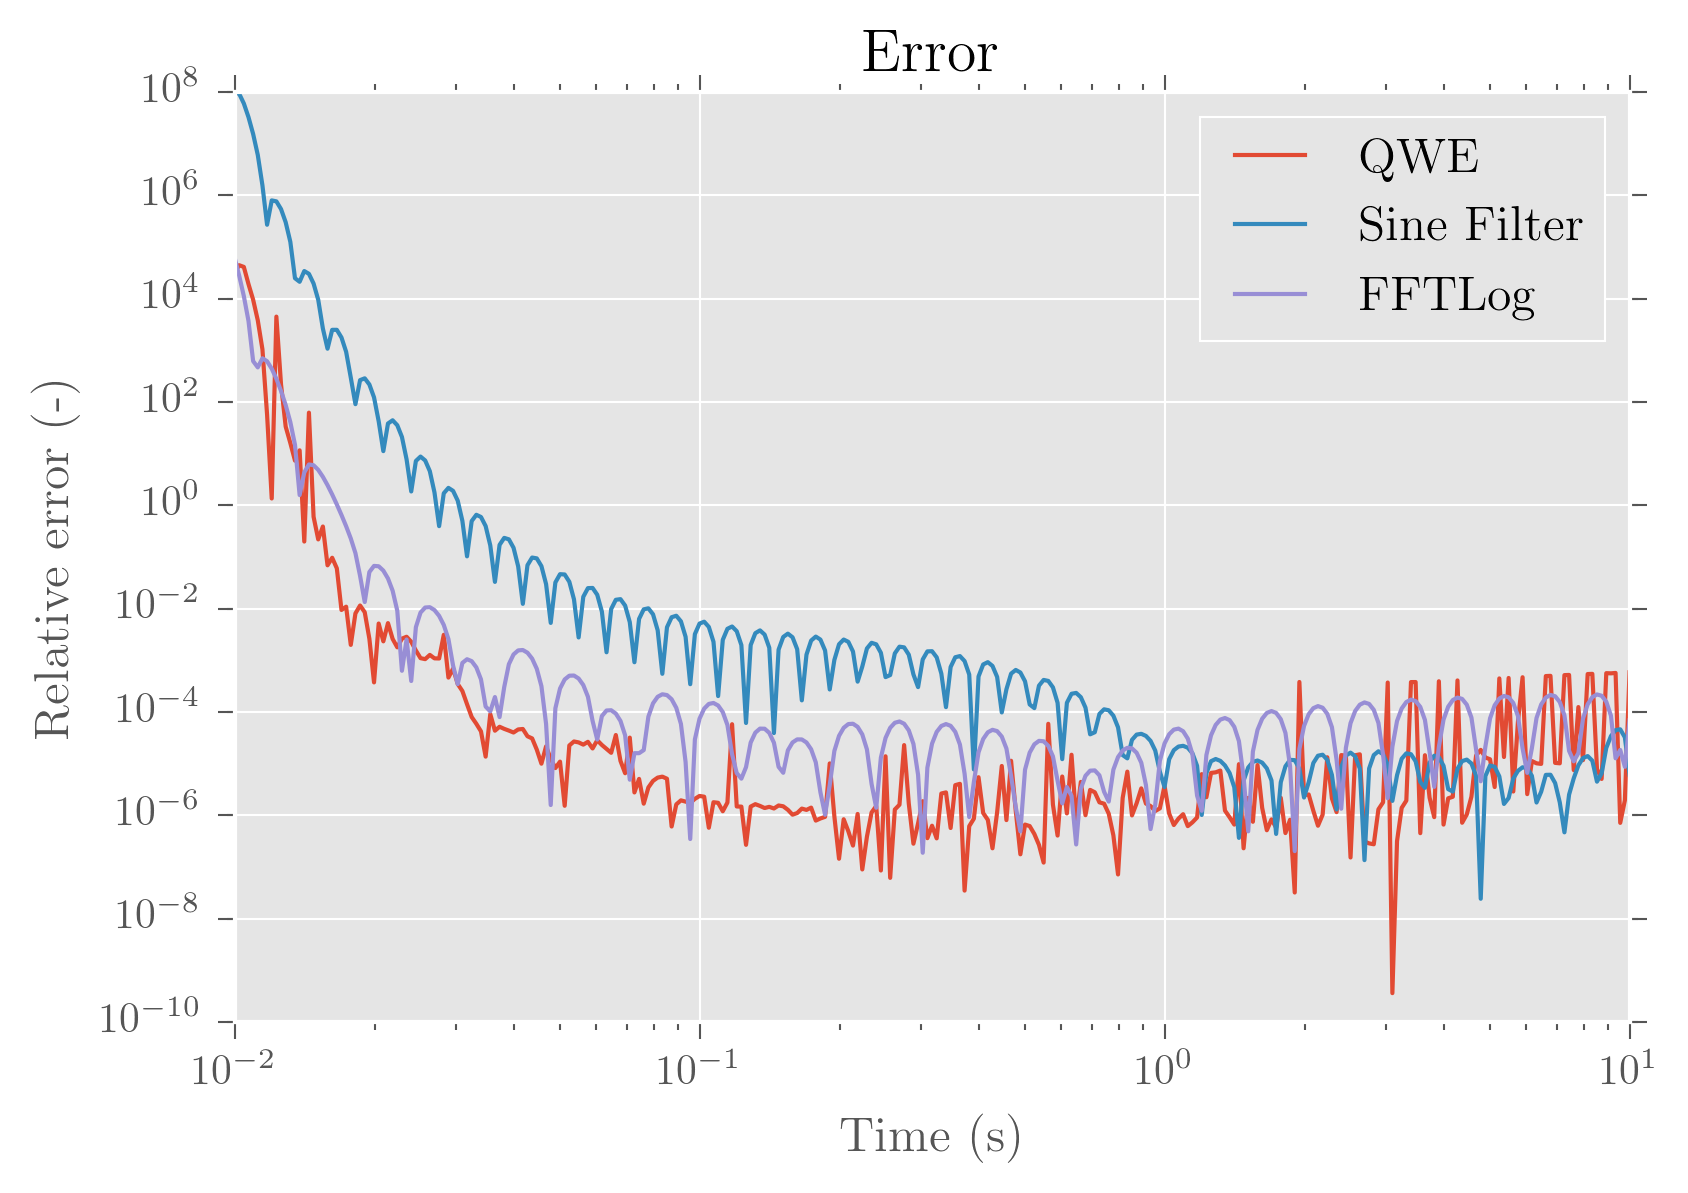

In [6]:
plt.figure()
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative error (-)')
plt.loglog(t, abs(qwe-ex)/ex, '-', label='QWE')
plt.plot(t, abs(sin-ex)/ex, '-', label='Sine Filter')
plt.plot(t, abs(ftl-ex)/ex, '-', label='FFTLog')
plt.legend(loc='best')
plt.show()

### Step response

In [7]:
ex = ee_xx_step(res[1], aniso[1], rec[0], t)

inparg['signal'] = 1 # signal 1 = step
print('QWE')
qwe = time(**inparg, ft='qwe', ftarg=[1e-6, 1e-18])
print('FHT (Sine)')
sin = time(**inparg, ft='sin')
print('FFTLog')
ftl = time(**inparg, ft='fftlog', ftarg=['', [-2, 4]])

QWE

:: empymod END; runtime = 0:00:09.952805 ::

FHT (Sine)

:: empymod END; runtime = 0:00:02.531111 ::

FFTLog

:: empymod END; runtime = 0:00:00.899744 ::



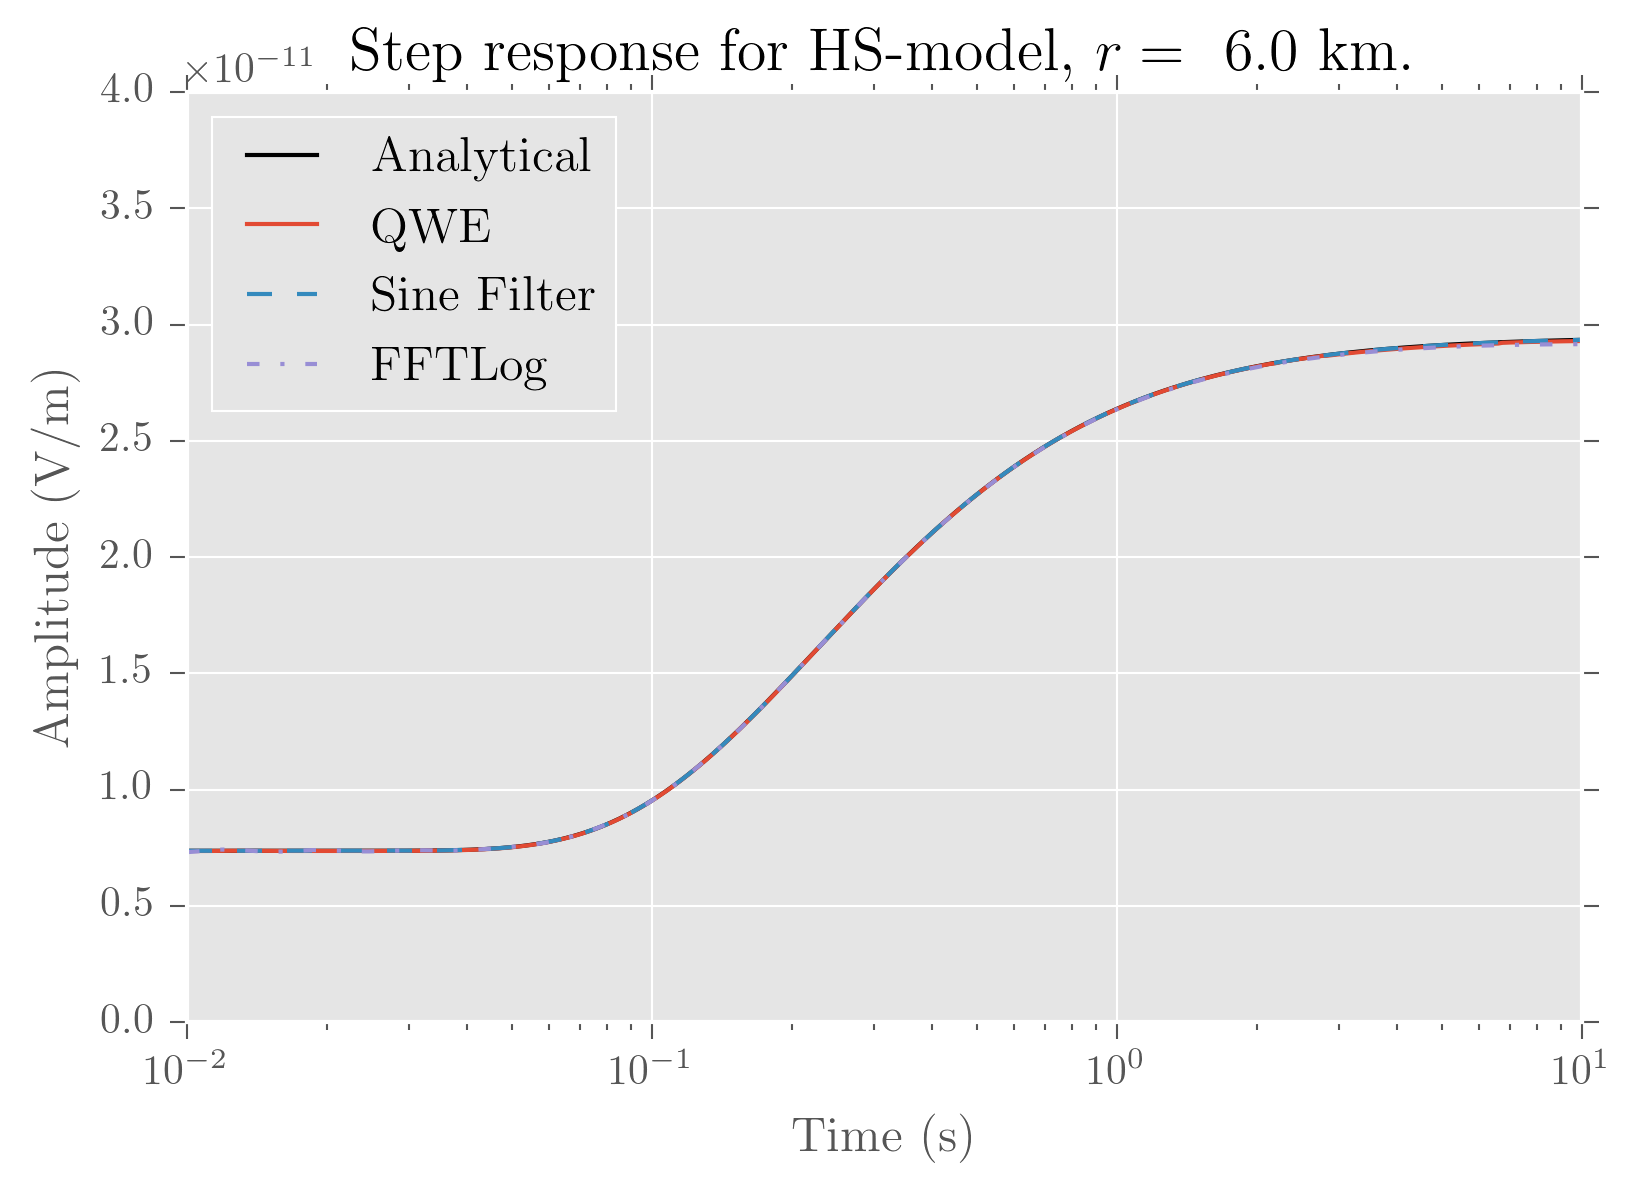

In [8]:
plt.figure()
plt.title(r'Step response for HS-model, $r =\ $ ' + str(rec[0]/1000) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V/m)')
plt.semilogx(t, ex, 'k-', label='Analytical')
plt.semilogx(t, qwe, '-', label='QWE')
plt.semilogx(t, sin, '--', label='Sine Filter')
plt.semilogx(t, ftl, '-.', label='FFTLog')
plt.ylim([0, 4e-11])
plt.legend(loc='best')
plt.show()

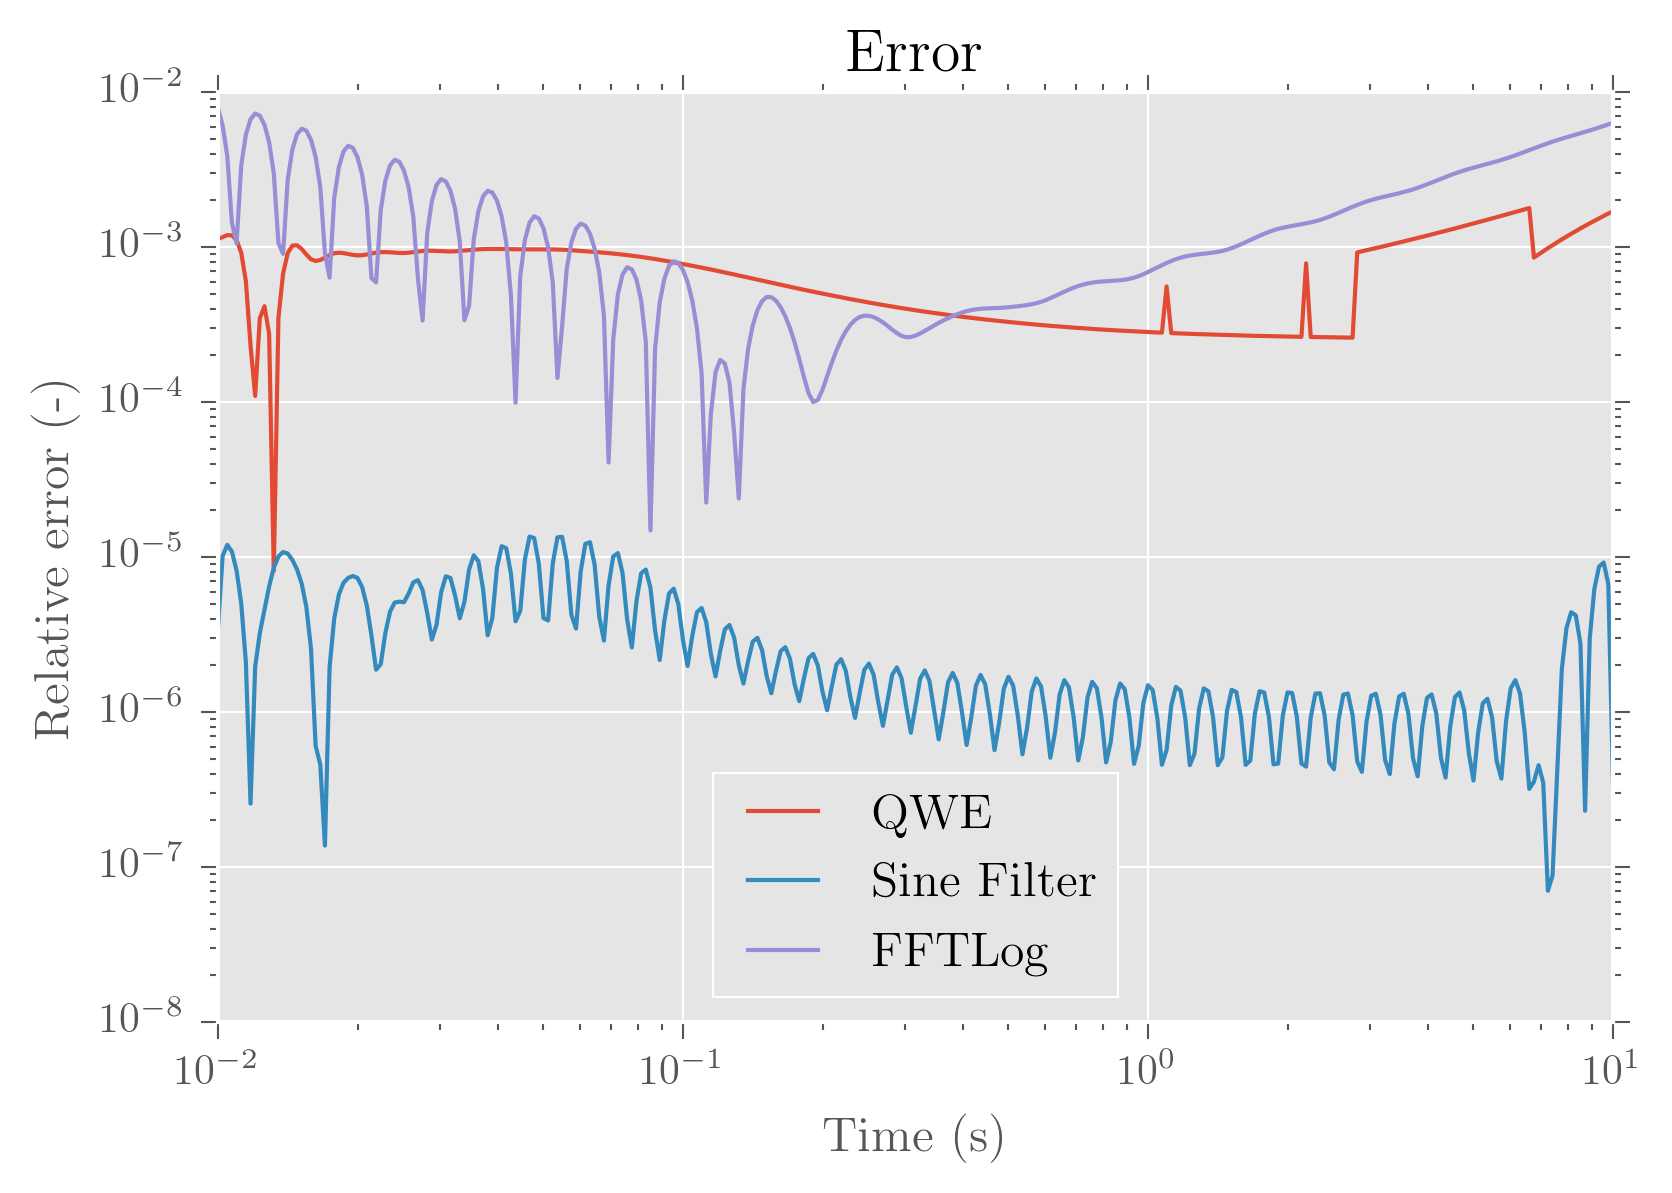

In [9]:
plt.figure()
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative error (-)')
plt.loglog(t, abs(qwe-ex)/ex, '-', label='QWE')
plt.plot(t, abs(sin-ex)/ex, '-', label='Sine Filter')
plt.plot(t, abs(ftl-ex)/ex, '-', label='FFTLog')
plt.legend(loc='best')
plt.show()

## Example 2: Air-seawater-halfspace

In [10]:
src = [0, 0, 950]            # Source 50 m above seabottom
rec = [6000, 0, 1000]        # Receivers in-line, at seabottom
res = [1e23, 1/3, 10]        # Resistivity: [air, water, half-space]
aniso = [1, 1, 2]            # Anisotropy: [air, water, half-space]
t = np.logspace(-2, 1, 301)  # Desired times (s)

# Collect parameters
inparg = {'src': src, 'rec': rec, 'depth': [0, 1000], 'time': t, 'res': res, 'aniso': aniso, 'verb': 1,
          'ht': 'qwe', 'htarg': [1e-8, 1e-20, 31, 40]}  # Use QWE for Hankel transform

### Impulse response

In [11]:
inparg['signal'] = 0 # signal 0 = impulse
print('QWE')
qwe = time(**inparg, ft='qwe', ftarg=['', '', '', 500])
print('FHT (Sine)')
sin = time(**inparg, ft='sin')
print('FFTLog')
ftl = time(**inparg, ft='fftlog')

QWE

:: empymod END; runtime = 0:00:05.853123 ::

FHT (Sine)

:: empymod END; runtime = 0:00:01.908336 ::

FFTLog

:: empymod END; runtime = 0:00:00.567035 ::



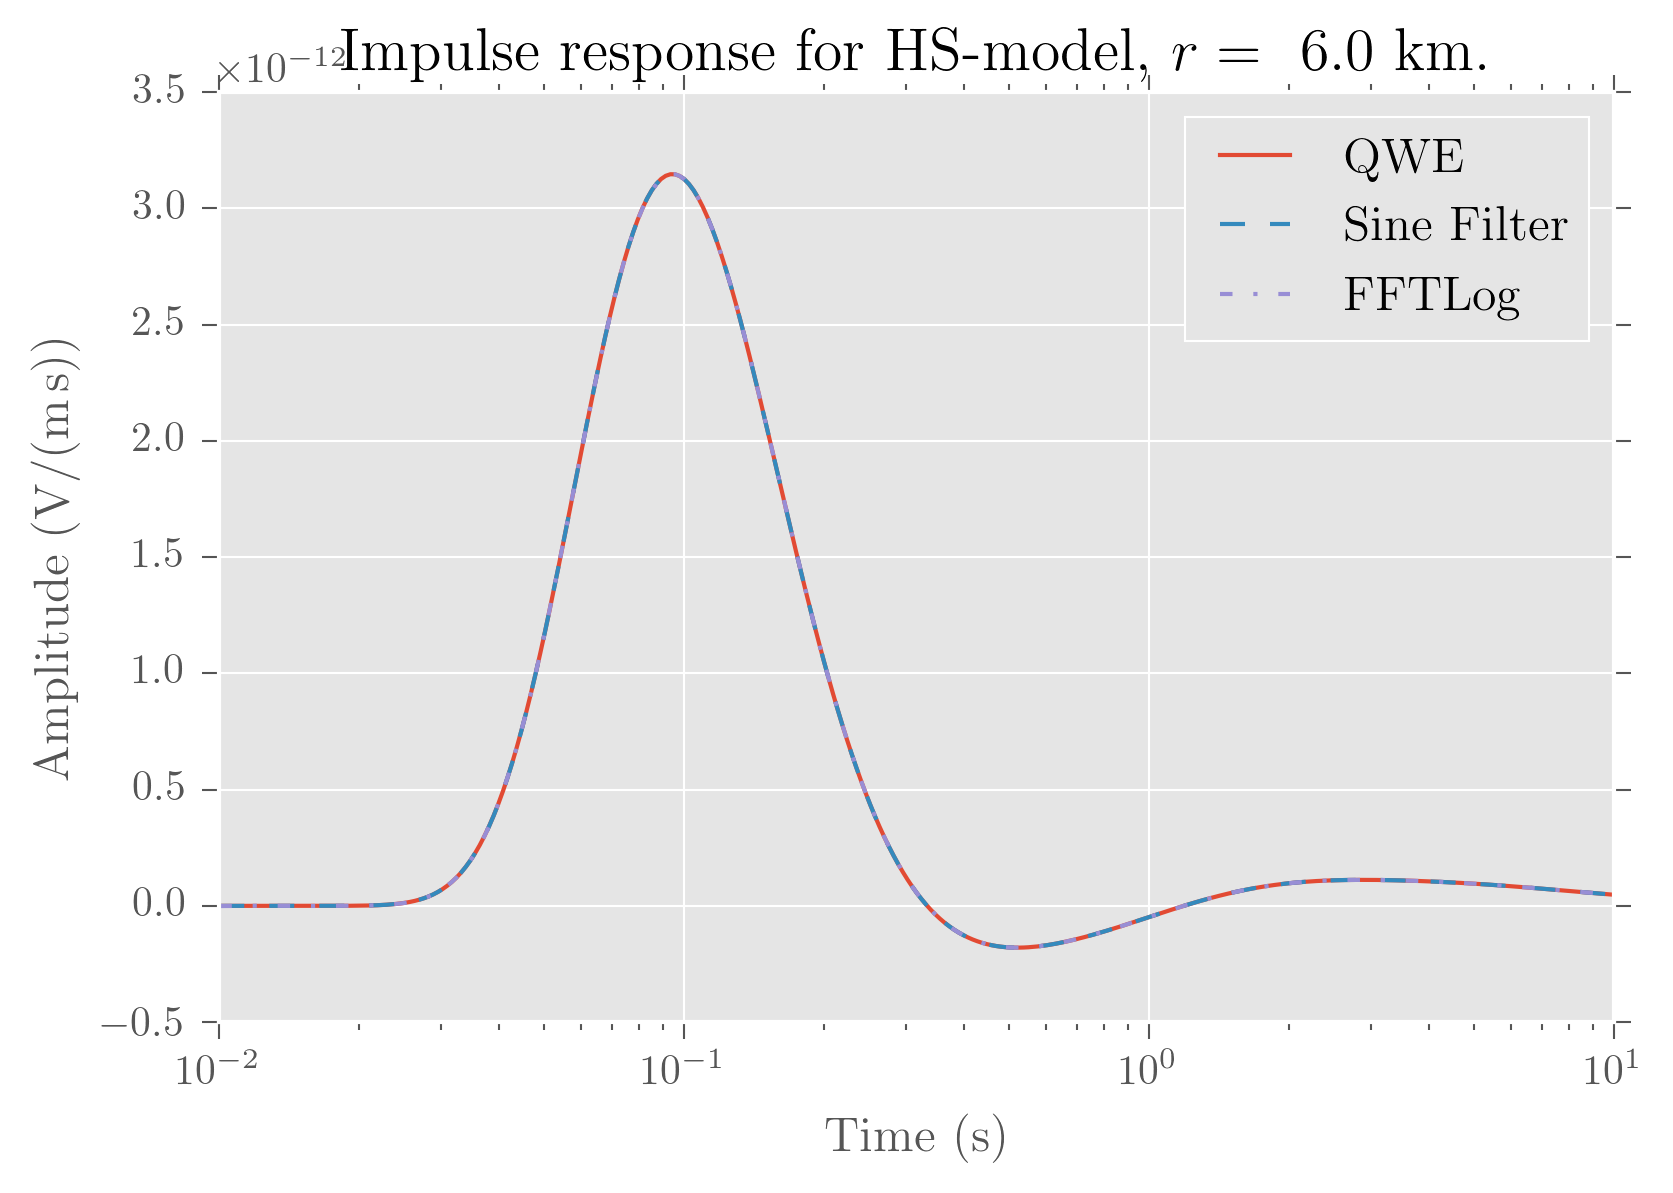

In [12]:
plt.figure()
plt.title(r'Impulse response for HS-model, $r =\ $ ' + str(rec[0]/1000) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel(r'Amplitude (V/(m\,s))')
plt.semilogx(t, qwe, '-', label='QWE')
plt.semilogx(t, sin, '--', label='Sine Filter')
plt.semilogx(t, ftl, '-.', label='FFTLog')
plt.legend(loc='best')
plt.show()

### Step response

In [13]:
inparg['signal'] = 1 # signal 1 = step
print('QWE')
qwe = time(**inparg, ft='qwe', ftarg=[1e-6, 1e-18])
print('FHT (Sine)')
sin = time(**inparg, ft='sin')
print('FFTLog')
ftl = time(**inparg, ft='fftlog', ftarg=['', [-2, 4]])

QWE


/home/dwerthmuller/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/dwerthmuller/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)



:: empymod END; runtime = 0:00:05.449505 ::

FHT (Sine)

:: empymod END; runtime = 0:00:01.888211 ::

FFTLog

:: empymod END; runtime = 0:00:00.770981 ::



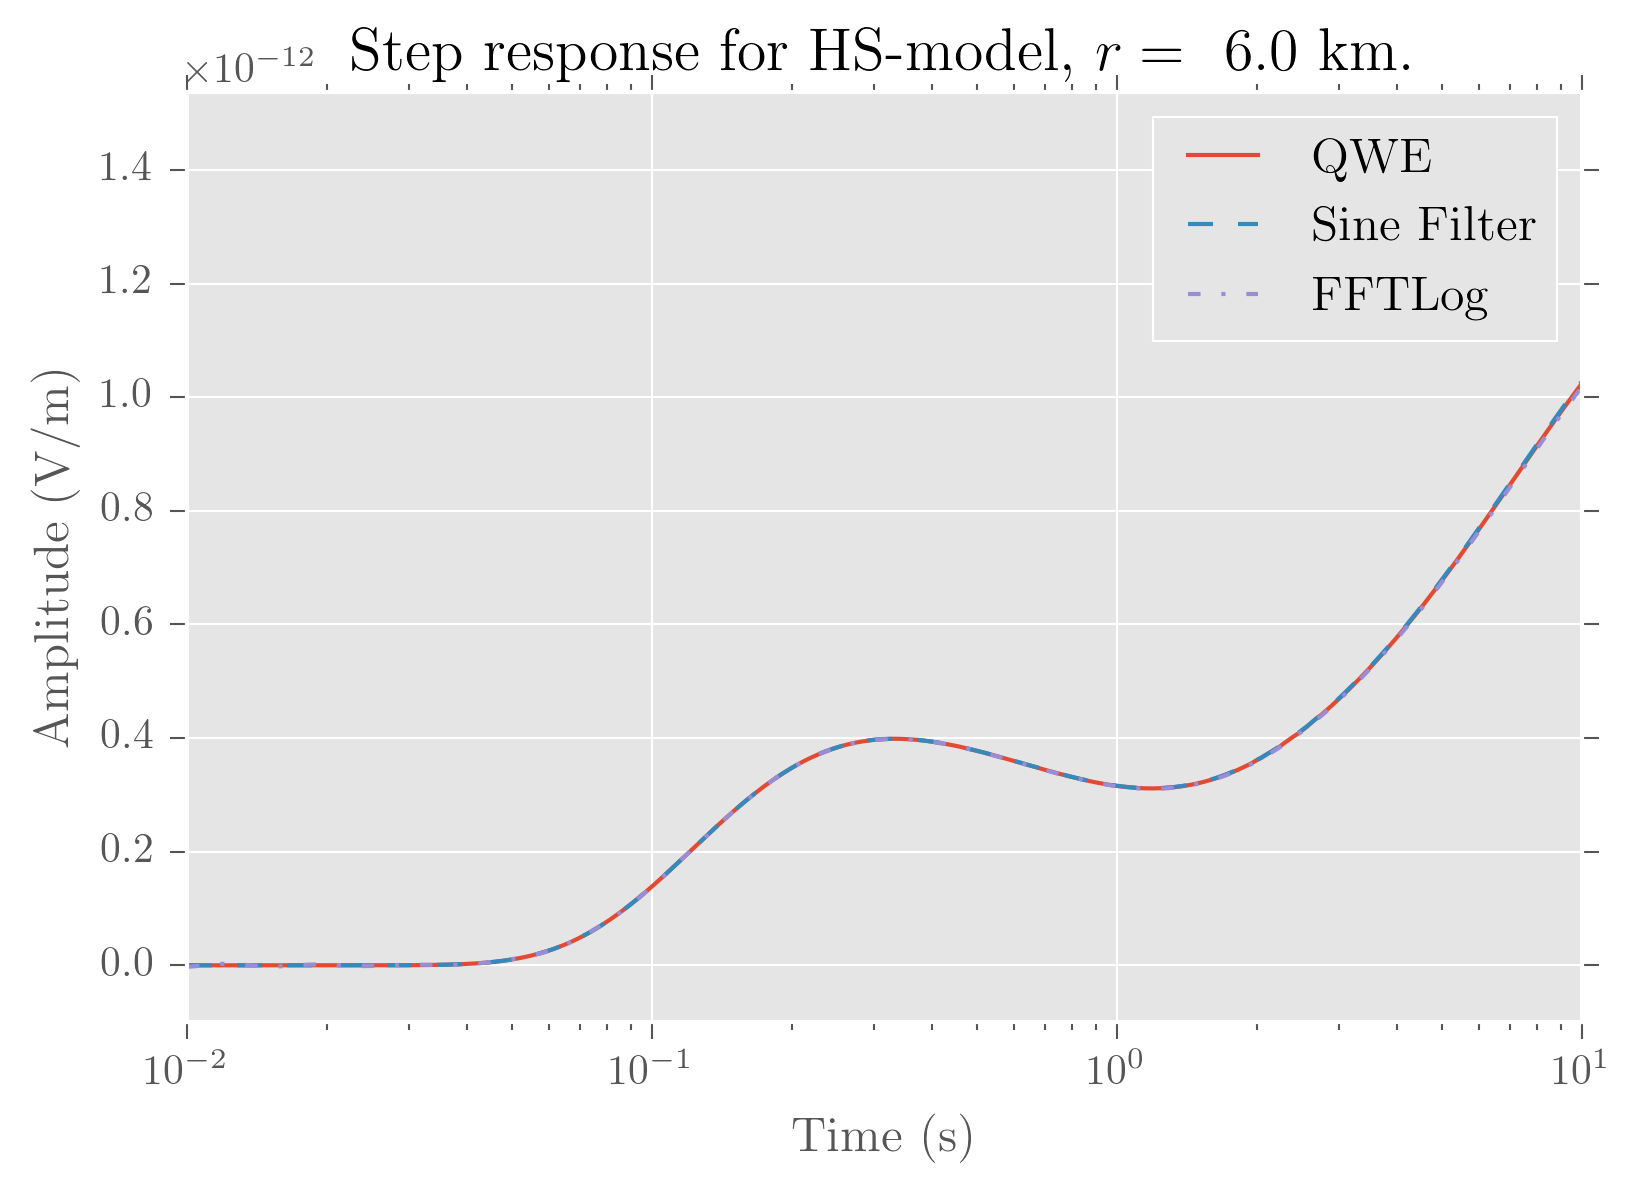

In [14]:
plt.figure()
plt.title(r'Step response for HS-model, $r =\ $ ' + str(rec[0]/1000) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V/m)')
plt.semilogx(t, qwe, '-', label='QWE')
plt.semilogx(t, sin, '--', label='Sine Filter')
plt.semilogx(t, ftl, '-.', label='FFTLog')
plt.ylim([-.1e-12, 1.5*qwe.max()])
plt.legend(loc='best')
plt.show()